In [79]:
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch import nn, optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

from scipy.stats import norm

# Set the seed for reproducibility
torch.manual_seed(42)

In [80]:
# Hyperparameters
IMAGE_SIZE = 32
BATCH_SIZE = 100
VALIDATION_SPLIT = 0.2
EMBEDDING_DIM = 2
EPOCHS = 5
BETA = 500

In [81]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Pad(2)
])

# download the dataset
train_dataset = datasets.FashionMNIST(root='data', train=True, download=True, transform=transform)
test_dataset = datasets.FashionMNIST(root='data', train=False, download = True, transform=transform)

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

train_dataset, test_dataset

(Dataset FashionMNIST
     Number of datapoints: 60000
     Root location: data
     Split: Train
     StandardTransform
 Transform: Compose(
                ToTensor()
                Pad(padding=2, fill=0, padding_mode=constant)
            ),
 Dataset FashionMNIST
     Number of datapoints: 10000
     Root location: data
     Split: Test
     StandardTransform
 Transform: Compose(
                ToTensor()
                Pad(padding=2, fill=0, padding_mode=constant)
            ))

In [82]:
for img, label in train_dataset:
    print(img.shape)
    print(label)
    break

torch.Size([1, 32, 32])
9


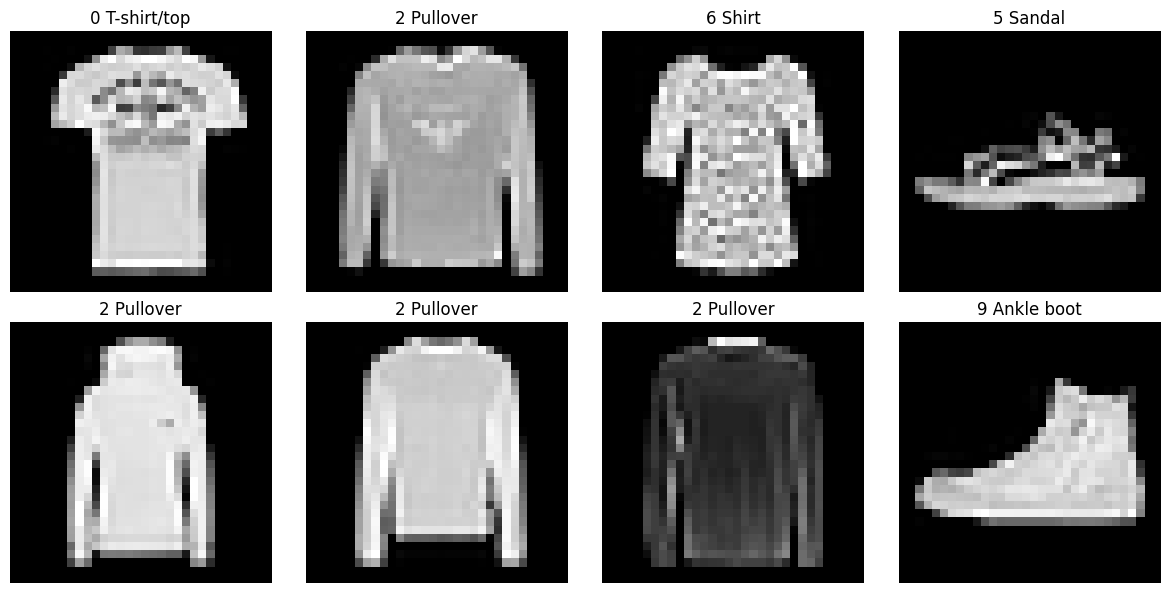

In [83]:
def plot_random_images(dataset, num_images=8, seed=42):
    np.random.seed(seed)
    random_indices = np.random.choice(range(len(dataset)), num_images, replace=False)

    fig, axes = plt.subplots(2, 4, figsize=(12,6))

    for i, idx in enumerate(random_indices):
        img, label = dataset[idx]
        img = img.numpy().squeeze()
        ax = axes[i//4, i%4]
        ax.imshow(img, cmap='gray')
        ax.set_title(f"{label} {dataset.classes[label]}")
        ax.axis('off')

    plt.tight_layout()
    plt.show()

plot_random_images(train_dataset, seed = 0)

### Build the variational autoencoder

In [84]:
class Sampling(nn.Module):
    def forward(self, z_mean, z_log_var):
        batch = z_mean.size(0)
        dim = z_mean.size(1)
        epsilon = torch.randn(batch, dim, device=z_mean.device)
        return z_mean + torch.exp(0.5 * z_log_var) * epsilon

In [85]:
import torch.nn.functional as F

class EncoderModel(nn.Module):
    def __init__(self, image_size, embedding_dim):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=2, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1)
        self.flatten = nn.Flatten()
        self.fc_mean = nn.Linear(128 * (image_size // 8) * (image_size // 8), embedding_dim)
        self.fc_log_var = nn.Linear(128 * (image_size // 8) * (image_size // 8), embedding_dim)
        self.sampling = Sampling()

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        shape_before_flattening = x.shape[1:] # Save the shape for the decoder
        x = self.flatten(x)
        z_mean = self.fc_mean(x)
        z_log_var = self.fc_log_var(x)
        z = self.sampling(z_mean, z_log_var)
        return z_mean, z_log_var, z, shape_before_flattening
    
encoder = EncoderModel(IMAGE_SIZE, EMBEDDING_DIM)
print(encoder)

EncoderModel(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc_mean): Linear(in_features=2048, out_features=2, bias=True)
  (fc_log_var): Linear(in_features=2048, out_features=2, bias=True)
  (sampling): Sampling()
)


In [86]:
from torchsummary import summary
summary(encoder, (1, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 16, 16]             320
            Conv2d-2             [-1, 64, 8, 8]          18,496
            Conv2d-3            [-1, 128, 4, 4]          73,856
           Flatten-4                 [-1, 2048]               0
            Linear-5                    [-1, 2]           4,098
            Linear-6                    [-1, 2]           4,098
          Sampling-7                    [-1, 2]               0
Total params: 100,868
Trainable params: 100,868
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.13
Params size (MB): 0.38
Estimated Total Size (MB): 0.51
----------------------------------------------------------------


### Decoder

In [87]:
class DecoderModel(nn.Module):
    def __init__(self, shape_before_flattening = (128, 4, 4)):
        super().__init__()
        self.linear1 = nn.Linear(EMBEDDING_DIM, np.prod(shape_before_flattening))
        self.unflatten = nn.Unflatten(1, shape_before_flattening)
        self.convtranspose1 = nn.ConvTranspose2d(shape_before_flattening[0], 128, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.convtranspose2 = nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.convtranspose3 = nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.conv1 = nn.Conv2d(32, 1, kernel_size=3, stride=1, padding=1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.linear1(x)
        x = self.unflatten(x)
        x = F.relu(self.convtranspose1(x))
        x = F.relu(self.convtranspose2(x))
        x = F.relu(self.convtranspose3(x))
        x = self.sigmoid(self.conv1(x))
        return x


In [88]:
from torchsummary import summary



# Instantiate the decoder model
decoder = DecoderModel(shape_before_flattening = (128, 4, 4))

# Print the model summary
summary(decoder, (2,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                 [-1, 2048]           6,144
         Unflatten-2            [-1, 128, 4, 4]               0
   ConvTranspose2d-3            [-1, 128, 8, 8]         147,584
   ConvTranspose2d-4           [-1, 64, 16, 16]          73,792
   ConvTranspose2d-5           [-1, 32, 32, 32]          18,464
            Conv2d-6            [-1, 1, 32, 32]             289
           Sigmoid-7            [-1, 1, 32, 32]               0
Total params: 246,273
Trainable params: 246,273
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.48
Params size (MB): 0.94
Estimated Total Size (MB): 1.42
----------------------------------------------------------------


### VAE model

In [89]:
class VAE(nn.Module):
    def __init__(self, encoder, decoder, beta=1.0):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.beta = beta
        self.total_loss_tracker = []
        self.reconstruction_loss_tracker = []
        self.kl_loss_tracker = []

    def forward(self, x):
        z_mean, z_log_var, z, shape_before_flattening = self.encoder(x)
        reconstruction = self.decoder(z)
        return z_mean, z_log_var, reconstruction
    
    def compute_loss(self, x, reconstruction, z_mean, z_log_var):
        reconstruction_loss = F.binary_cross_entropy(reconstruction, x, reduction='sum')
        kl_loss = -0.5 * torch.sum(1 + z_log_var - z_mean.pow(2) - z_log_var.exp())
        total_loss = reconstruction_loss + self.beta * kl_loss
        return total_loss, reconstruction_loss, kl_loss
    
    def train_step(self, data, optimizer):
        self.train()
        optimizer.zero_grad()
        z_mean, z_log_var, reconstruction = self(data)
        total_loss, reconstruction_loss, kl_loss = self.compute_loss(data, reconstruction, z_mean, z_log_var)
        total_loss.backward()
        optimizer.step()

        self.total_loss_tracker.append(total_loss.item())
        self.reconstruction_loss_tracker.append(reconstruction_loss.item())
        self.kl_loss_tracker.append(kl_loss.item())

        return {
            "total_loss": total_loss.item(),
            "reconstruction_loss": reconstruction_loss.item(),
            "kl_loss": kl_loss.item()
        }
    
    def test_step(self, data):
        self.eval()
        with torch.inference_mode():
            z_mean, z_log_var, reconstruction = self(data)
            total_loss, reconstruction_loss, kl_loss = self.compute_loss(data, reconstruction, z_mean, z_log_var)

        return {
                "total_loss": total_loss.item(),
                "reconstruction_loss": reconstruction_loss.item(),
                "kl_loss": kl_loss.item()
            }
    
    @property
    def metrics(self):
        return {
            "total_loss": sum(self.total_loss_tracker) / len(self.total_loss_tracker),
            "reconstruction_loss": sum(self.reconstruction_loss_tracker) / len(self.reconstruction_loss_tracker),
            "kl_loss": sum(self.kl_loss_tracker) / len(self.kl_loss_tracker)
        }
        


In [90]:
from torch.optim import Adam

# Create a variational autoencoder
vae = VAE(encoder, decoder, beta=BETA)
optimizer = Adam(vae.parameters(), lr = 0.0005)


In [91]:
from torch.utils.tensorboard import SummaryWriter

# Tensorboard setup
writer = SummaryWriter(log_dir="./logs")

In [92]:
import os
best_loss = float('inf')

os.makedirs("./models", exist_ok=True)

checkpoint_dir = "./checkpoint"
os.makedirs(checkpoint_dir, exist_ok=True)
checkpoint_path = os.path.join(checkpoint_dir, "vae.pth")

In [93]:


for epoch in range(EPOCHS):
    vae.train()
    train_loss = 0
    for batch in train_dataloader:
        data, _ = batch
        metrics = vae.train_step(data, optimizer)
        train_loss += metrics["total_loss"]

    train_loss /= len(train_dataloader)
    writer.add_scalar('Loss/train', train_loss, epoch)

    vae.eval()
    val_loss = 0
    with torch.inference_mode():
        for batch in test_dataloader:
            data, _ = batch
            metrics = vae.test_step(data)
            val_loss += metrics["total_loss"]

    val_loss /= len(test_dataloader)
    writer.add_scalar('Loss/val', val_loss, epoch)

    print(f"Epoch {epoch+1}, Train Loss: {train_loss}, Val Loss: {val_loss}")

    # Save the best model
    if val_loss < best_loss:
        best_loss = val_loss
        torch.save(vae.state_dict(), checkpoint_path)

# Save the final models

torch.save(vae.state_dict(), "./models/vae.pth")
torch.save(encoder.state_dict(), "./models/encoder.pth")
torch.save(decoder.state_dict(), './models/decoder.pth')

# Close the Tensorboard writer
writer.close()

Epoch 1, Train Loss: 40007.743815104164, Val Loss: 38559.30640625
Epoch 2, Train Loss: 38481.11337890625, Val Loss: 38558.8547265625
Epoch 3, Train Loss: 38480.7561328125, Val Loss: 38525.4232421875
Epoch 4, Train Loss: 38469.151868489585, Val Loss: 38587.5415234375
Epoch 5, Train Loss: 38468.20806640625, Val Loss: 38520.5356640625


In [99]:
test_dataset

Dataset FashionMNIST
    Number of datapoints: 10000
    Root location: data
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
               Pad(padding=2, fill=0, padding_mode=constant)
           )

In [100]:
test_loader = DataLoader(test_dataset, batch_size=5000, shuffle=False)
# Select the first 5000 images from the test set
example_images, example_labels = next(iter(test_loader))

In [102]:
example_images.shape

torch.Size([5000, 1, 32, 32])

Example real clothing items


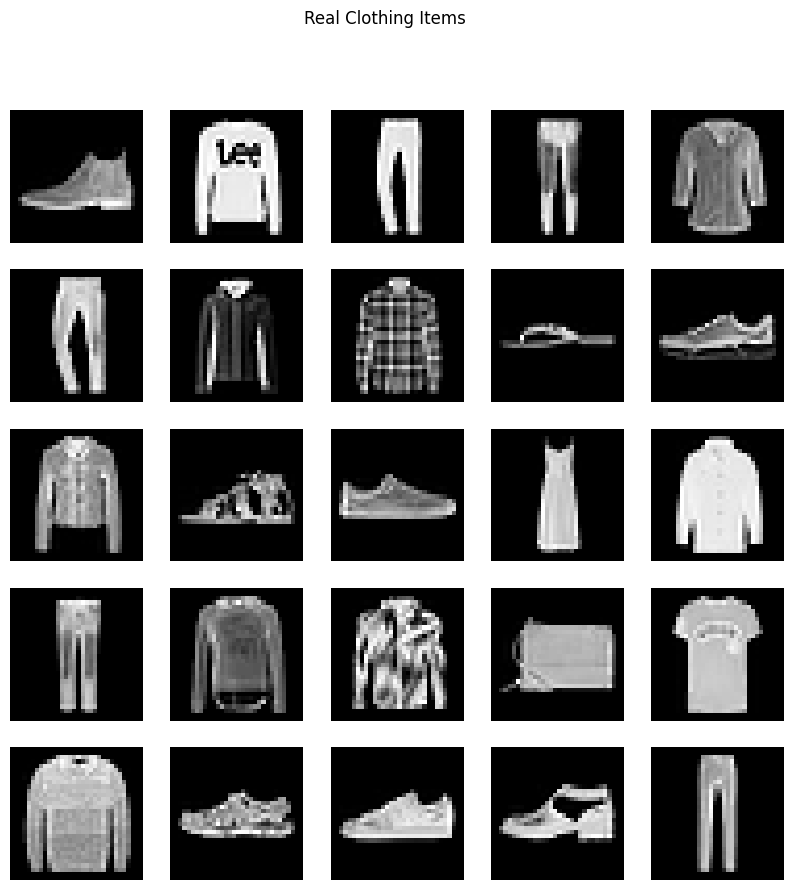

Reconstructions


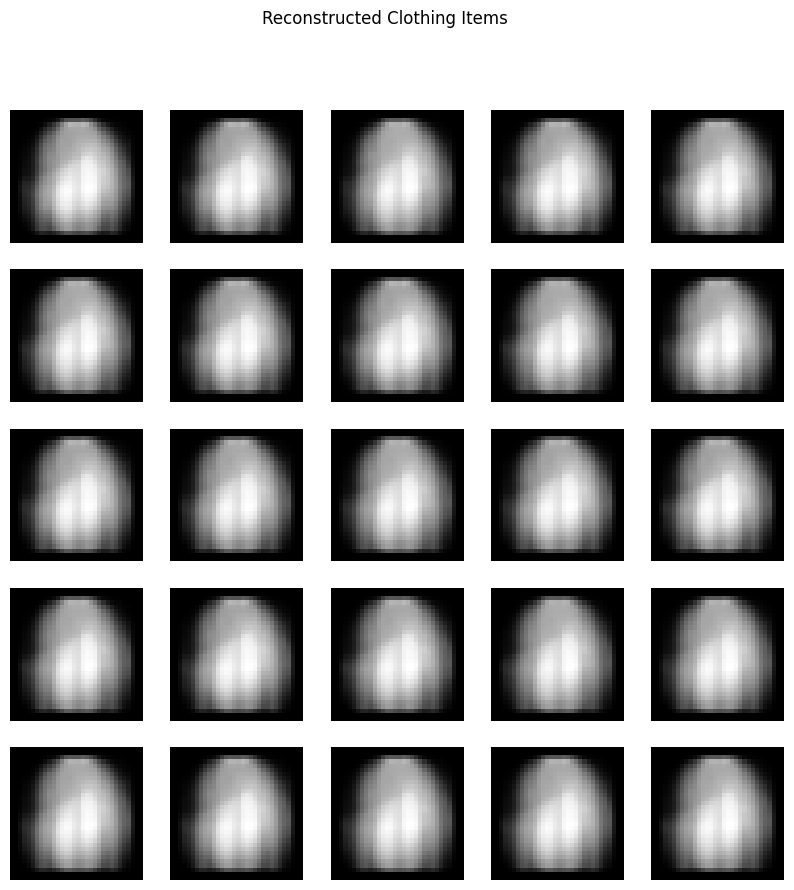

In [105]:
# Ensure the model is in evaluation mode
vae.eval()

# Create autoencoder predictions
with torch.no_grad():
    z_mean, z_log_var, reconstructions = vae(example_images)

# Convert tensors to numpy arrays for display
example_images_np = example_images.numpy()
reconstructions_np = reconstructions.numpy()

# Function to display images
def display(images, title):
    plt.figure(figsize=(10, 10))
    for i in range(25):
        plt.subplot(5, 5, i + 1)
        plt.imshow(images[i].reshape(32, 32), cmap='gray')
        plt.axis('off')
    plt.suptitle(title)
    plt.show()

# Display example real clothing items
print("Example real clothing items")
display(example_images_np, "Real Clothing Items")

# Display reconstructions
print("Reconstructions")
display(reconstructions_np, "Reconstructed Clothing Items")

In [104]:
32*32

1024

In [106]:
import tensorflow as tf
from tensorflow import keras